In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler ,MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans 

In [2]:


df = pd.read_csv('/content/df2.csv', delimiter = ',')
df=df.drop("class",axis=1)
df.head()

,Make,Model,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),Age,km_year,prestige
0,Toyota,Prius,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0,11,17727.272727,2
1,Renault,Grand Scenic,Universal,135000.0,1500.0,Diesel,Manual,8550.0,8,16875.000000,2
2,Renault,Laguna,Universal,110000.0,1500.0,Diesel,Manual,6550.0,10,11000.000000,3
3,Opel,Astra,Universal,200000.0,1600.0,Metan/Propan,Manual,4100.0,16,12500.000000,3
4,Mercedes,Vito,Microvan,300000.0,2200.0,Diesel,Manual,3490.0,22,13636.363636,4


In [3]:
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

In [4]:
display(categorical_features)
display(numerical_features)
     

['Make', 'Model', 'Style', 'Fuel_type', 'Transmission']

['Distance',
 'Engine_capacity(cm3)',
 'Price(euro)',
 'Age',
 'km_year',
 'prestige']

In [5]:
X=df[numerical_features]

In [6]:
scale=StandardScaler()
X=scale.fit_transform(X)
     

In [7]:
class KMeans_1(object):
    
    def __init__(self): #No need to implement
        pass
    
    def pairwise_dist(self, x, y): # [5 pts]
        """
        Args:
            x: N x D numpy array
            y: M x D numpy array
        Return:
                dist: N x M array, where dist2[i, j] is the euclidean distance between 
                x[i, :] and y[j, :]
                """
        x2 = np.sum(x**2, 1)
        y2 = np.sum(y**2, 1)
        xy = x @ y.T
        d2 = -2 * xy + y2 + x2[:, np.newaxis]
        d2[d2 < 0] = 0
        return np.sqrt(d2)

    def _init_centers(self, points, K, **kwargs): # [5 pts]
        """
        Args:
            points: NxD numpy array, where N is # points and D is the dimensionality
            K: number of clusters
            kwargs: any additional arguments you want
        Return:
            centers: K x D numpy array, the centers. 
        """
        idx = np.random.randint(points.shape[0], size=K)
        return points[idx, :]

    def _update_assignment(self, centers, points): # [10 pts]
        """
        Args:
            centers: KxD numpy array, where K is the number of clusters, and D is the dimension
            points: NxD numpy array, the observations
        Return:
            cluster_idx: numpy array of length N, the cluster assignment for each point
            
        Hint: You could call pairwise_dist() function.
        """
        dist = self.pairwise_dist(points, centers) #NxK
        return np.argmin(dist, 1)

    def _update_centers(self, old_centers, cluster_idx, points): # [10 pts]
        """
        Args:
            old_centers: old centers KxD numpy array, where K is the number of clusters, and D is the dimension
            cluster_idx: numpy array of length N, the cluster assignment for each point
            points: NxD numpy array, the observations
        Return:
            centers: new centers, K x D numpy array, where K is the number of clusters, and D is the dimension.
        """
        weights = np.zeros((points.shape[0], old_centers.shape[0])) #NxK
        weights[np.arange(points.shape[0]), cluster_idx] = 1
        
        sums = np.einsum('NK,ND->KD', weights, points)
        return sums / np.sum(weights, 0)[:, np.newaxis]

    def _get_loss(self, centers, cluster_idx, points): # [5 pts]
        """
        Args:
            centers: KxD numpy array, where K is the number of clusters, and D is the dimension
            cluster_idx: numpy array of length N, the cluster assignment for each point
            points: NxD numpy array, the observations
        Return:
            loss: a single float number, which is the objective function of KMeans. 
        """
        chosen_centers = centers[cluster_idx, :] #NxD
        return np.sum((chosen_centers - points) ** 2)
        
    def __call__(self, points, K, max_iters=100, abs_tol=1e-16, rel_tol=1e-16, verbose=False, **kwargs):
        """
        Args:
            points: NxD numpy array, where N is # points and D is the dimensionality
            K: number of clusters
            max_iters: maximum number of iterations (Hint: You could change it when debugging)
            abs_tol: convergence criteria w.r.t absolute change of loss
            rel_tol: convergence criteria w.r.t relative change of loss
            verbose: boolean to set whether method should print loss (Hint: helpful for debugging)
            kwargs: any additional arguments you want
        Return:
            cluster assignments: Nx1 int numpy array
            cluster centers: K x D numpy array, the centers
            loss: final loss value of the objective function of KMeans
        """
        centers = self._init_centers(points, K, **kwargs)
        for it in range(max_iters):
            cluster_idx = self._update_assignment(centers, points)
            centers = self._update_centers(centers, cluster_idx, points)
            loss = self._get_loss(centers, cluster_idx, points)
            K = centers.shape[0]
            if it:
                diff = np.abs(prev_loss - loss)
                if diff < abs_tol and diff / prev_loss < rel_tol:
                    break
            prev_loss = loss
            if verbose:
                print('iter %d, loss: %.4f' % (it, loss))
        return cluster_idx, centers, loss
    
    def find_optimal_num_clusters(self, data, max_K=15): # [10 pts]
        """Plots loss values for different number of clusters in K-Means
        
        Args:
            image: input image of shape(H, W, 3)
            max_K: number of clusters
        Return:
            losses: an array of loss denoting the loss of each number of clusters
        """
        
        x = np.arange(1, max_K)
        y = np.zeros(x.shape)
        for i in range(max_K - 1):
            cluster_idx, centers, loss = self.__call__(data, i + 1)
            y[i] = loss
        fig = plt.figure()
        plt.plot(x, y)
        plt.show()
        return y

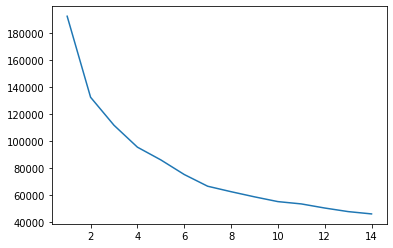

array([192444.        , 132501.77848309, 111787.38831321,  95581.67177044,
        86159.97918341,  75355.58536241,  66684.98229425,  62636.61572243,
        58830.52837843,  55302.6802099 ,  53592.49723324,  50553.93655862,
        47912.51315558,  46194.85981117])

In [8]:
KMeans_1().find_optimal_num_clusters(X)

<Figure size 720x432 with 0 Axes>

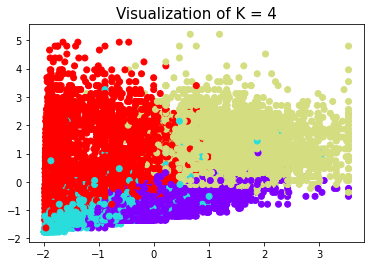

In [9]:

def visualise(X, C, K):# Visualization of clustering. You don't need to change this function  
    plt.figure(figsize=(10,6)) 
    fig, ax = plt.subplots()
    ax.scatter(X[:, 0], X[:, 3], c=C,cmap='rainbow')
    plt.title('Visualization of K = '+str(K), fontsize=15)
    plt.show()
    pass
    
cluster_idx1, centers1, loss1 = KMeans_1()(X, 4)
visualise(X, cluster_idx1, 4)


In [10]:
y0=pd.DataFrame(cluster_idx1).value_counts()
y0

0    10792
2     8354
3     7957
1     4971
dtype: int64

<Figure size 720x432 with 0 Axes>

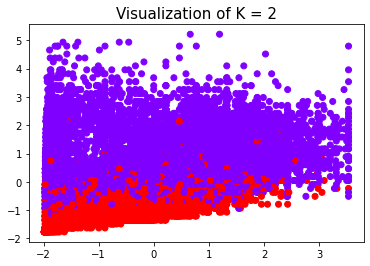

In [11]:
cluster_idx1, centers1, loss1 = KMeans_1()(X, 2)
visualise(X, cluster_idx1, 2)

In [12]:
y1_1=cluster_idx1

In [13]:
y1=pd.DataFrame(cluster_idx1).value_counts()
y1

0    17215
1    14859
dtype: int64

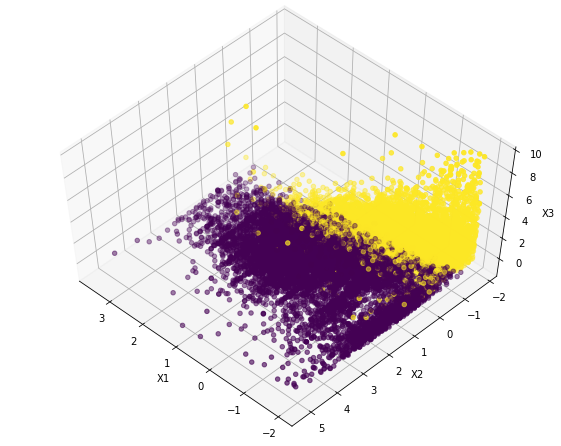

In [14]:
import mpl_toolkits

from mpl_toolkits.mplot3d import Axes3D
fig=plt.figure(1,figsize=(8,6))
plt.clf()
ax=Axes3D(fig,rect=[0,0,.95,1],elev=58,azim=134)
ax.set_xlabel("X1")
ax.set_ylabel("X2")
ax.set_zlabel("X3")

ax.scatter(X[:,0],X[:,3],X[:,2],c=cluster_idx1.astype(float))

In [15]:
from sklearn.cluster import KMeans 

In [16]:

def findOptimalK():
    wcss = list()
    for k in range(1, 15):
        kmeans = KMeans(n_clusters=k)
        kmeans = kmeans.fit(X)
        wcss.append(kmeans.inertia_)
        
    plt.figure(figsize=(15, 6))
    plt.plot(range(1, 15), wcss, marker = "o")

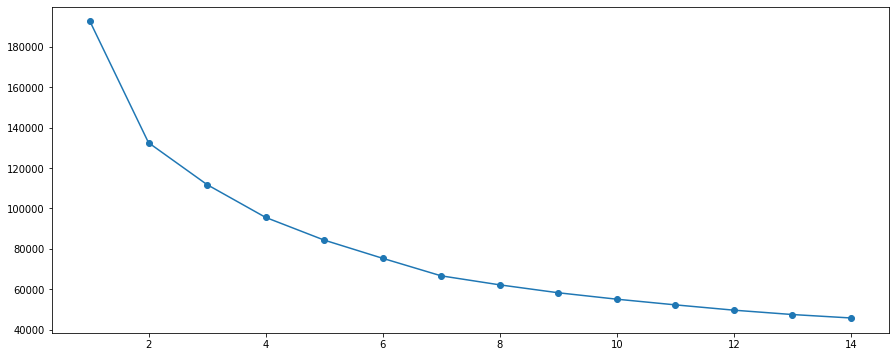

In [17]:

findOptimalK()

In [18]:

k_means = KMeans(init = "k-means++", n_clusters = 2, n_init = 35)
k_means.fit(X)

KMeans(n_clusters=2, n_init=35)

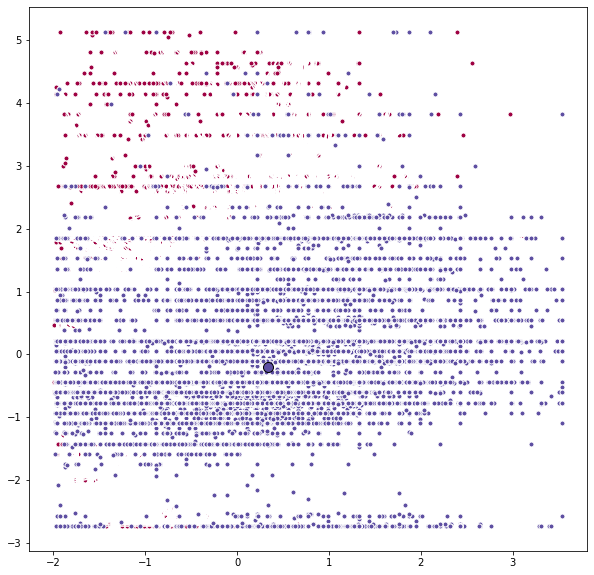

In [19]:
k_means_cluster_centers = k_means.cluster_centers_
k_means_labels = k_means.labels_
fig = plt.figure(figsize=(10, 10))

colors = plt.cm.Spectral(np.linspace(0, 1, len(set(k_means_labels))))

ax = fig.add_subplot(1, 1, 1,)
for k, col in zip(range(len(k_means.cluster_centers_)), colors):
    my_members = (k_means_labels == k)
    cluster_center = k_means_cluster_centers[k]
    ax.plot(X[my_members, 0],X[my_members, 1], 'w', markerfacecolor=col, marker='.',markersize=10)
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,  markeredgecolor='k', markersize=10)
plt.show()
     

In [20]:
df1 = pd.read_csv('/content/df2_cat.csv', delimiter = ',')
df1.head()

,Make,Model,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),Age,km_year,class,prestige
0,40,82,4,195000.0,1800.0,2,1,7750.0,11,17727.272727,4,2
1,32,52,11,135000.0,1500.0,0,0,8550.0,8,16875.000000,4,2
2,32,61,11,110000.0,1500.0,0,0,6550.0,10,11000.000000,3,3
3,28,13,11,200000.0,1600.0,3,0,4100.0,16,12500.000000,3,3
4,23,116,5,300000.0,2200.0,0,0,3490.0,22,13636.363636,3,4


In [21]:

scale=StandardScaler()
X=scale.fit_transform(df1)

In [22]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca.fit(X)
X_new = pca.transform(X)

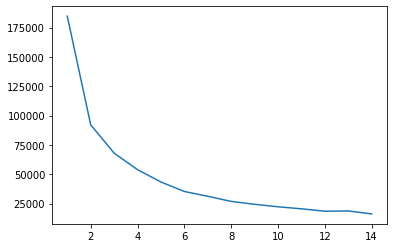

array([184602.78191969,  92103.49303755,  68028.12582091,  53908.06077021,
        43399.0421194 ,  35349.73837989,  31226.43797394,  26898.79559857,
        24413.29422667,  22298.68178365,  20562.92353475,  18521.22477803,
        18772.12728506,  16223.44820318])

In [23]:
KMeans_1().find_optimal_num_clusters(X_new)

In [24]:

def visualise(X, C, K):# Visualization of clustering. You don't need to change this function  
    plt.figure(figsize=(10,6)) 
    fig, ax = plt.subplots()
    ax.scatter(X[:, 0], X[:, 1], c=C,cmap='rainbow')
    plt.title('Visualization of K = '+str(K), fontsize=15)
    plt.show()
    pass

<Figure size 720x432 with 0 Axes>

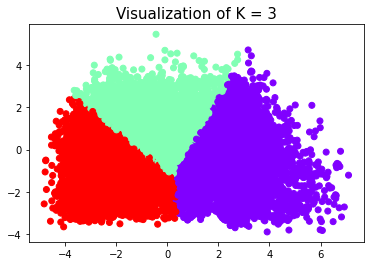

In [25]:
cluster_idx1, centers1, loss1 = KMeans_1()(X_new, 3)
visualise(X_new, cluster_idx1, 3)

In [26]:

pd.crosstab(y1_1,cluster_idx1, rownames=['Метки'], colnames = ['Предсказания'])

Предсказания,0,1,2
Метки,,,
0,57,7416,9742
1,10342,4197,320
